<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

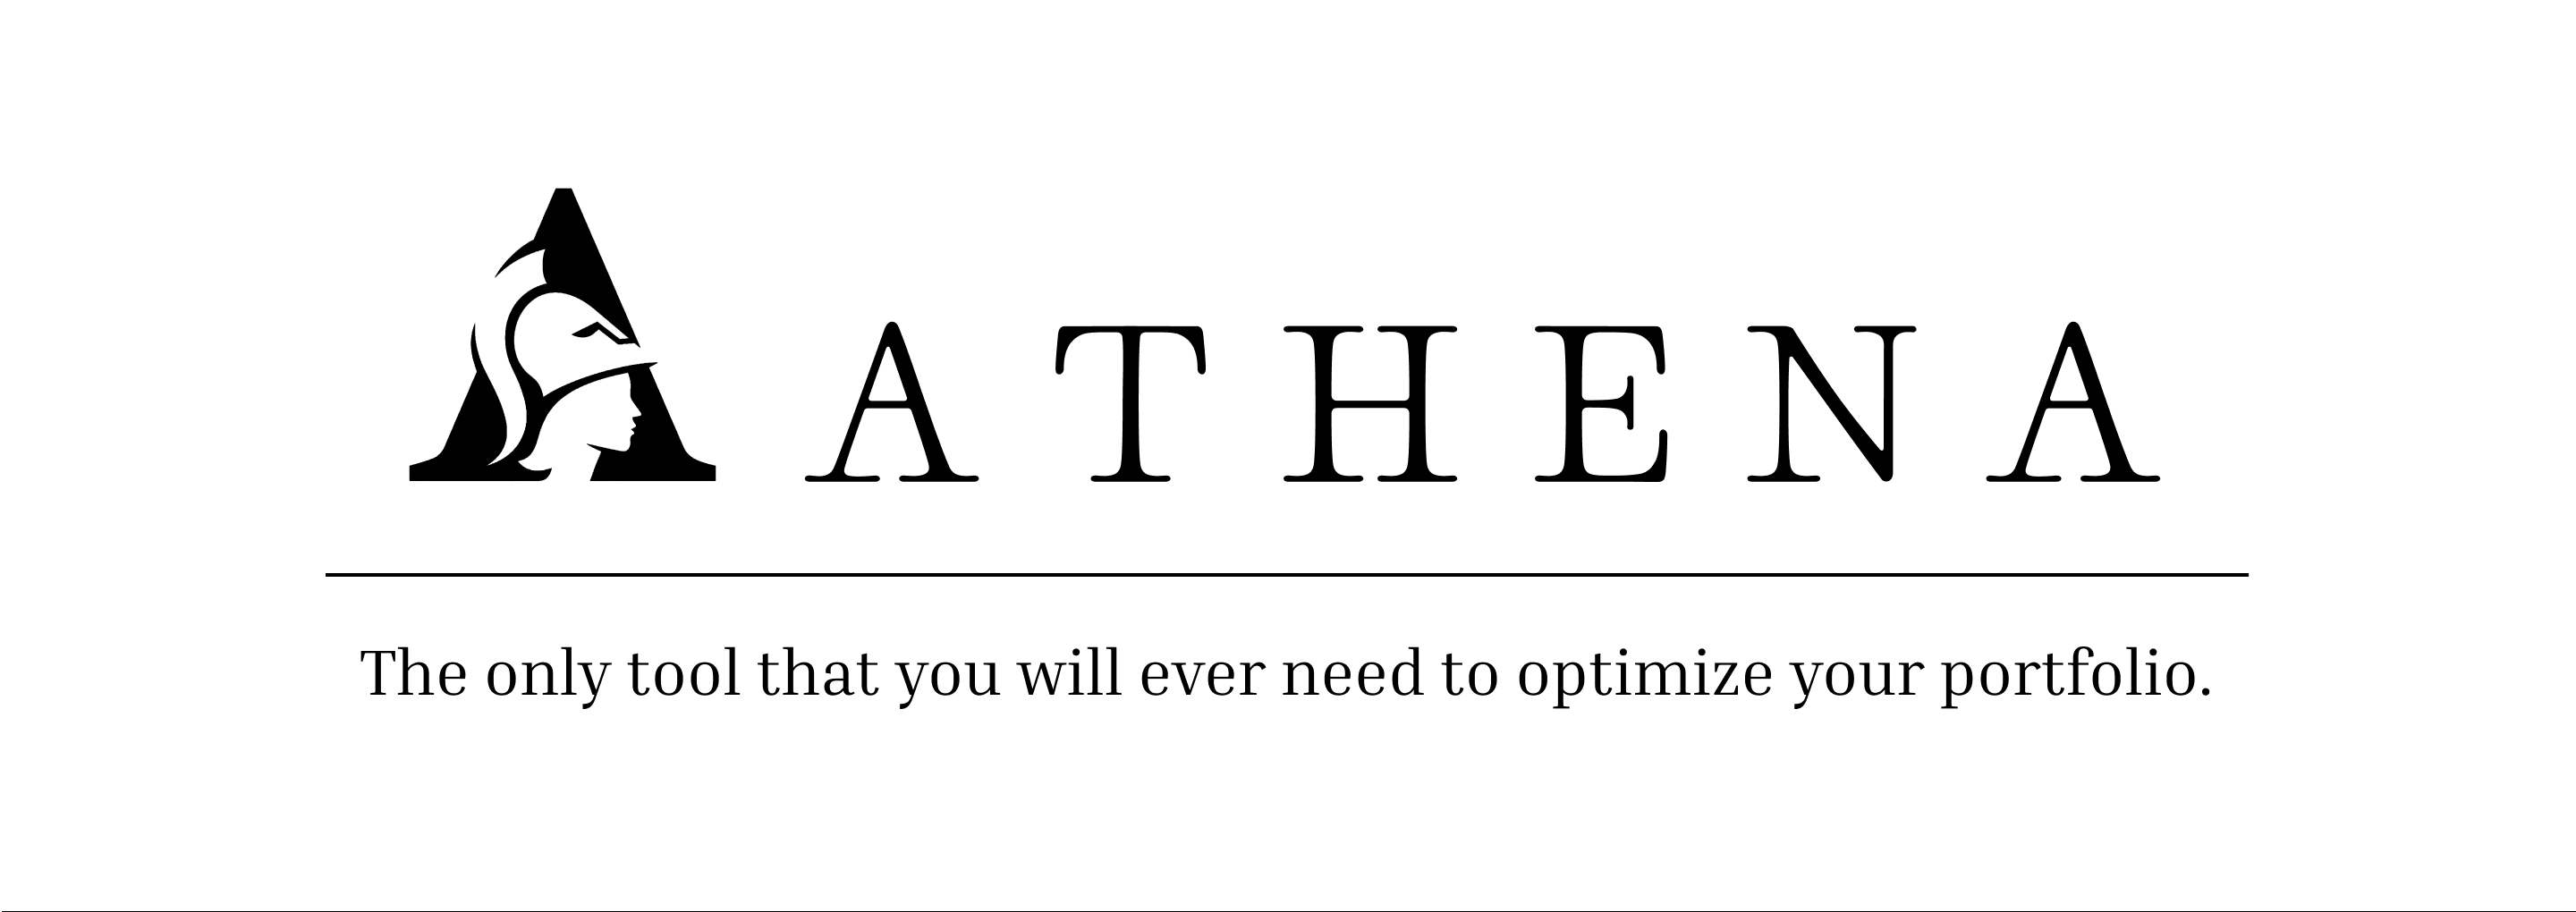

# Athena - Portfolio Optimization using Machine Learning

Athena uses a novel approach to portfolio optimization. It combines both deep learning and statistics along with asset fundamentals analysis to generate a robust portfolio with maximal returns and minimal risk. 

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [1]:
!pip install yfinance
!pip install PyPortfolioOpt
!pip install Riskfolio-Lib

In [2]:
import yfinance as yf
import riskfolio as rp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import scipy
import pandas as pd
# from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("-----------------------------")
print(f'Tensorflow version: {tf.__version__}')
# print(f'Matplotlib version: {matplotlib. __version__}')
print("All neccessary imports done!")

-----------------------------
Tensorflow version: 2.8.0
All neccessary imports done!


## Variables

**Sample Portfolio 1 [Random selection]**

1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. Pidilite Industries - PIDILITIND.NS
1. Lupin - LUPIN.NS
1. Indian Oil Corporation - IOC.NS

tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

---

**Sample Portfolio 2 [Selected based on popularity and market cap]**

1. Adani Ports - ADANIPORTS.NS
1. Asian Paints - ASIANPAINT.NS
1. Axis Bank - AXISBANK.NS
1. ICICI - ICICIBANK.NS
1. Cipla - CIPLA.NS
1. Infosys -  INFY.NS
1. Lupin - LUPIN.NS
1. Dr Reddys Labs - DRREDDY.NS
1. Coal India - COALINDIA.NS
1. Airtel - BHARTIARTL.NS
1. Deepak Nitrite - DEEPAKNTR.NS
1. Expleo Solutions - EXPLEOSOL.NS

tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "ICICIBANK.NS", "CIPLA.NS", "INFY.NS", "LUPIN.NS", "DRREDDY.NS", "COALINDIA.NS", "BHARTIARTL.NS", "DEEPAKNTR.NS", "EXPLEOSOL.NS"]

---

**Sample Portfolio 3 [Selected based on financial news sites suggestions without any fundamental analysis]** 

1. Coforge - COFORGE.NS
1. State bank of India - SBIN.NS
1. Blue star - BLUESTARCO.NS
1. Zen Technologies - ZENTEC.NS
1. Cummins India - CUMMINSIND.NS
1. Trent - TRENT.NS
1. Tata Power - TATAPOWER.NS
1. Vardhman Textiles - VTL.NS
1. Birlasoft - BSOFT.NS
1. APL Apollo Tubes - APLAPOLLO.NS
1. Dhampur Sugar Mills - DHAMPURSUG.NS

tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]

In [3]:
tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", 
           "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]
# sorting tickers
tickers.sort()

time_steps = 100 # the lookback period
features = 1 # We use only the close price
min_prev_days = 150
port_len = len(tickers) # length of portfolio

## Getting data from API (YFinance)

Reference - https://pypi.org/project/yfinance/

In [40]:
def get_data(tickers, getInfo=True, period="5y"):
  
  # download data of ticker symbol
  data = yf.download(tickers, period=period)
  
  if(getInfo):
    info = []

    for ticker in tickers: 
      info.append(yf.Ticker(ticker).info)

  # check whether if any ticker symbol has less than min_prev_days days of data
  for i in range(port_len):
    cur_ticker_count = data.iloc[:, i].count()

    if cur_ticker_count < min_prev_days:
      print(f'{tickers[i]} has less than {min_prev_days} days of historical price data. Please consider removing the asset or adding some other asset.')
      return None
    
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  if getInfo:
    return data, info
  else:
    return data

In [41]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# df, info = get_data(tickers)
df = get_data(tickers, getInfo=False, period="5y")

[*********************100%***********************]  11 of 11 completed


In [15]:
df = df.dropna()
df = df["Close"]
df

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-27,116.510002,620.549988,80.781067,425.100006,927.200012,226.949997,279.450012,87.300003,240.250000,261.250000,66.849998
2017-03-28,118.330002,615.900024,81.371620,425.000000,937.150024,224.050003,282.100006,88.800003,246.300003,259.989990,66.500000
2017-03-29,117.190002,651.099976,81.340538,425.549988,932.950012,214.399994,288.450012,90.000000,249.000000,258.630005,69.050003
2017-03-30,118.489998,668.299988,81.216209,420.049988,940.400024,219.949997,291.049988,89.900002,256.149994,262.320007,68.300003
2017-03-31,117.445000,692.400024,80.625664,435.600006,949.450012,216.850006,293.399994,90.349998,266.700012,262.529999,66.550003
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,963.849976,978.750000,443.750000,4433.899902,1054.000000,532.799988,490.600006,227.949997,1279.599976,520.869995,197.100006
2022-03-22,938.049988,984.750000,465.899994,4457.700195,1051.849976,533.799988,493.700012,231.399994,1286.349976,513.090027,195.750000
2022-03-23,908.700012,995.049988,467.549988,4435.450195,1087.050049,533.599976,490.649994,234.300003,1300.250000,527.789978,195.750000


## Converting company information to DataFrame

In [ ]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(info[0],orient='index')
infodf0 = infodf0.reset_index()
infodf0

## Visualizing the data

<AxesSubplot:xlabel='Date'>

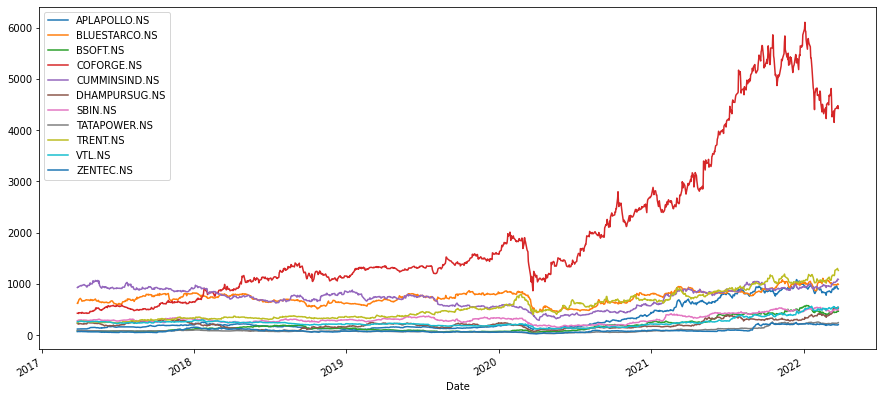

In [7]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df.plot(label = tickers, figsize = (15,7))

# Deep Learning model for future price prediction

## Preprocessing

In [ ]:
# shifting is done here to ensure that the next day's price is predicted on the given day
df_shift = df.shift(-1)

label = df_shift

print(label)

            ASIANPAINT.NS      IOC.NS     LUPIN.NS  PIDILITIND.NS  RELIANCE.NS
Date                                                                          
2017-03-23    1064.250000  186.350006  1487.800049     688.250000   637.333740
2017-03-24    1042.900024  185.449997  1457.750000     682.900024   619.676086
2017-03-27    1057.849976  184.524994  1455.699951     696.500000   617.026184
2017-03-28    1068.099976  185.074997  1454.349976     689.099976   622.425049
2017-03-29    1070.099976  188.399994  1446.949951     690.950012   629.359314
...                   ...         ...          ...            ...          ...
2022-03-16    3136.600098  121.349998   765.349976    2510.399902  2481.699951
2022-03-17    3045.750000  118.000000   755.150024    2485.250000  2467.399902
2022-03-21    3051.149902  120.650002   757.250000    2450.350098  2531.149902
2022-03-22    3007.300049  121.199997   752.500000    2421.899902  2542.000000
2022-03-23            NaN         NaN          NaN  

In [ ]:
# adjusting the shape of both df and label (since label contains NaN as the last value)

df.drop(df.index[len(df)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

In [ ]:
df

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-15,2987.149902,119.000000,737.950012,2370.550049,2363.449951
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951


In [ ]:
label

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-24,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-27,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-28,1068.099976,185.074997,1454.349976,689.099976,622.425049
2017-03-29,1070.099976,188.399994,1446.949951,690.950012,629.359314
...,...,...,...,...,...
2022-03-15,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-16,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-17,3045.750000,118.000000,755.150024,2485.250000,2467.399902


#### For portfolio [not important]

In [ ]:
df["ASIANPAINT.NS"].values.reshape(-1,1)

array([[1061.59997559],
       [1064.25      ],
       [1042.90002441],
       ...,
       [2987.14990234],
       [3042.        ],
       [3136.60009766]])

In [ ]:
x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))
X = []
Y = []

for t in tickers:
  scaled_t = x_scale.fit_transform(df[t].values.reshape(-1,1))
  scaled_label = y_scale.fit_transform(label[t].values.reshape(-1,1))
  
  X.append(scaled_t)
  Y.append(scaled_label)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(5, 1233, 1)
(5, 1233, 1)


#### For single asset and portfolio

In [ ]:
# conversion to numpy array

x, y = df.values, label.values

In [ ]:
# Scaling to normalize the data. MinMaxScaler scales all the data to be in the region of 0 and 1.

x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))

In [ ]:
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,port_len))

print(X.shape)
print(Y.shape)

print(X[0])
print(Y[time_steps])

(1235, 5)
(1235, 5)
[0.00834041 0.74999993 1.         0.0053002  0.0064524 ]
[0.03925707 0.9122272  0.41529208 0.06711196 0.07720612]


## Splitting train/test data and adding timesteps [Best Method]

### For portfolio [not important]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(len(X)):
  X_train, X_test, y_train, y_test = train_test_split(X[i], Y[i], test_size=0.4, shuffle=False)
  X_train_new.append(X_train)
  X_test_new.append(X_test)
  y_train_new.append(y_train)
  y_test_new.append(y_test)

X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(5, 739, 1)
(5, 739, 1)
(5, 494, 1)
(5, 494, 1)


### For single asset and portfolio


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(741, 5)
(741, 5)
(494, 5)
(494, 5)


#### Adding timesteps [Best Method]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(time_steps, len(X_train)):
  X_train_new.append(X_train[i-time_steps:i, :])
  y_train_new.append(y_train[i-1])
  


for i in range(time_steps, len(X_test)):
  X_test_new.append(X_test[i-time_steps:i, :])
  y_test_new.append(y_test[i-1])

#### Converting train and test to numpy arrays and reshaping

In [ ]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(641, 100, 5)
(641, 5)
(394, 100, 5)
(394, 5)


In [ ]:
y_train_new[0]

array([0.03726561, 0.90885743, 0.43189316, 0.06549044, 0.07526218])

In [ ]:
X_train_new = X_train_new.reshape(-1,time_steps,port_len)
X_test_new = X_test_new.reshape(-1,time_steps,port_len)

## Using timesteps (Method 2) [not important]

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))

df = scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# Training data is 60% of the whole data. The rest is test data
training_size=int(len(df)*0.6)
test_size=len(df)-training_size

train_data,test_data=df[0:training_size,:],df[training_size:len(df), :1]

In [ ]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):

    # a = dataset[i:(i+time_step), :]
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    # dataY.append(dataset[i + time_step, 3])
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(641, 100)
(394, 100)
(641,)
(394,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print(X_train.shape)
print(X_test.shape)

(641, 100, 1)
(394, 100, 1)


## Deep learning model (GRU)

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=256))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(port_len))

gru_model.compile(loss='mse', optimizer='adam')

In [ ]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 512)          795648    
                                                                 
 dropout_3 (Dropout)         (None, 100, 512)          0         
                                                                 
 gru_4 (GRU)                 (None, 256)               590592    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,387,525
Trainable params: 1,387,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  gru_model.fit(X_train_new,y_train_new,batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.0700 - val_loss: 0.0223
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/100
3/3 [==============================] - 3s 998ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 0.0023 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 3s 979ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
3/3 [==============================] - 3s 1s/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/100
3/3 [==============================] - 3s 994ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/100
3/3 [============

In [ ]:
gru_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print('GRU Model saved!')

GRU Model saved!


## Deep Learning Model (LSTM)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=256))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(port_len))

lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1060864   
                                                                 
 dropout_5 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,849,605
Trainable params: 1,849,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(X_train_new, y_train_new, batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 13s 3s/step - loss: 0.0691 - val_loss: 0.0210
Epoch 2/100
3/3 [==============================] - 10s 4s/step - loss: 0.0159 - val_loss: 0.0177
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.0186 - val_loss: 0.0039
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.0061 - val_loss: 0.0155
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0.0025 - val_loss: 0.0032
Epoch 11/100
3/3 [===================

In [ ]:
# Saving the model in drive
lstm_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/LSTM_port_len_5_features_1_timesteps_100.h5")
print('LSTM Model saved!') 

LSTM Model saved!


## Prediction

In [ ]:
model = lstm_model

13/13 [==============================] - 2s 129ms/step - loss: 0.0042
Score: 0.0041625648736953735


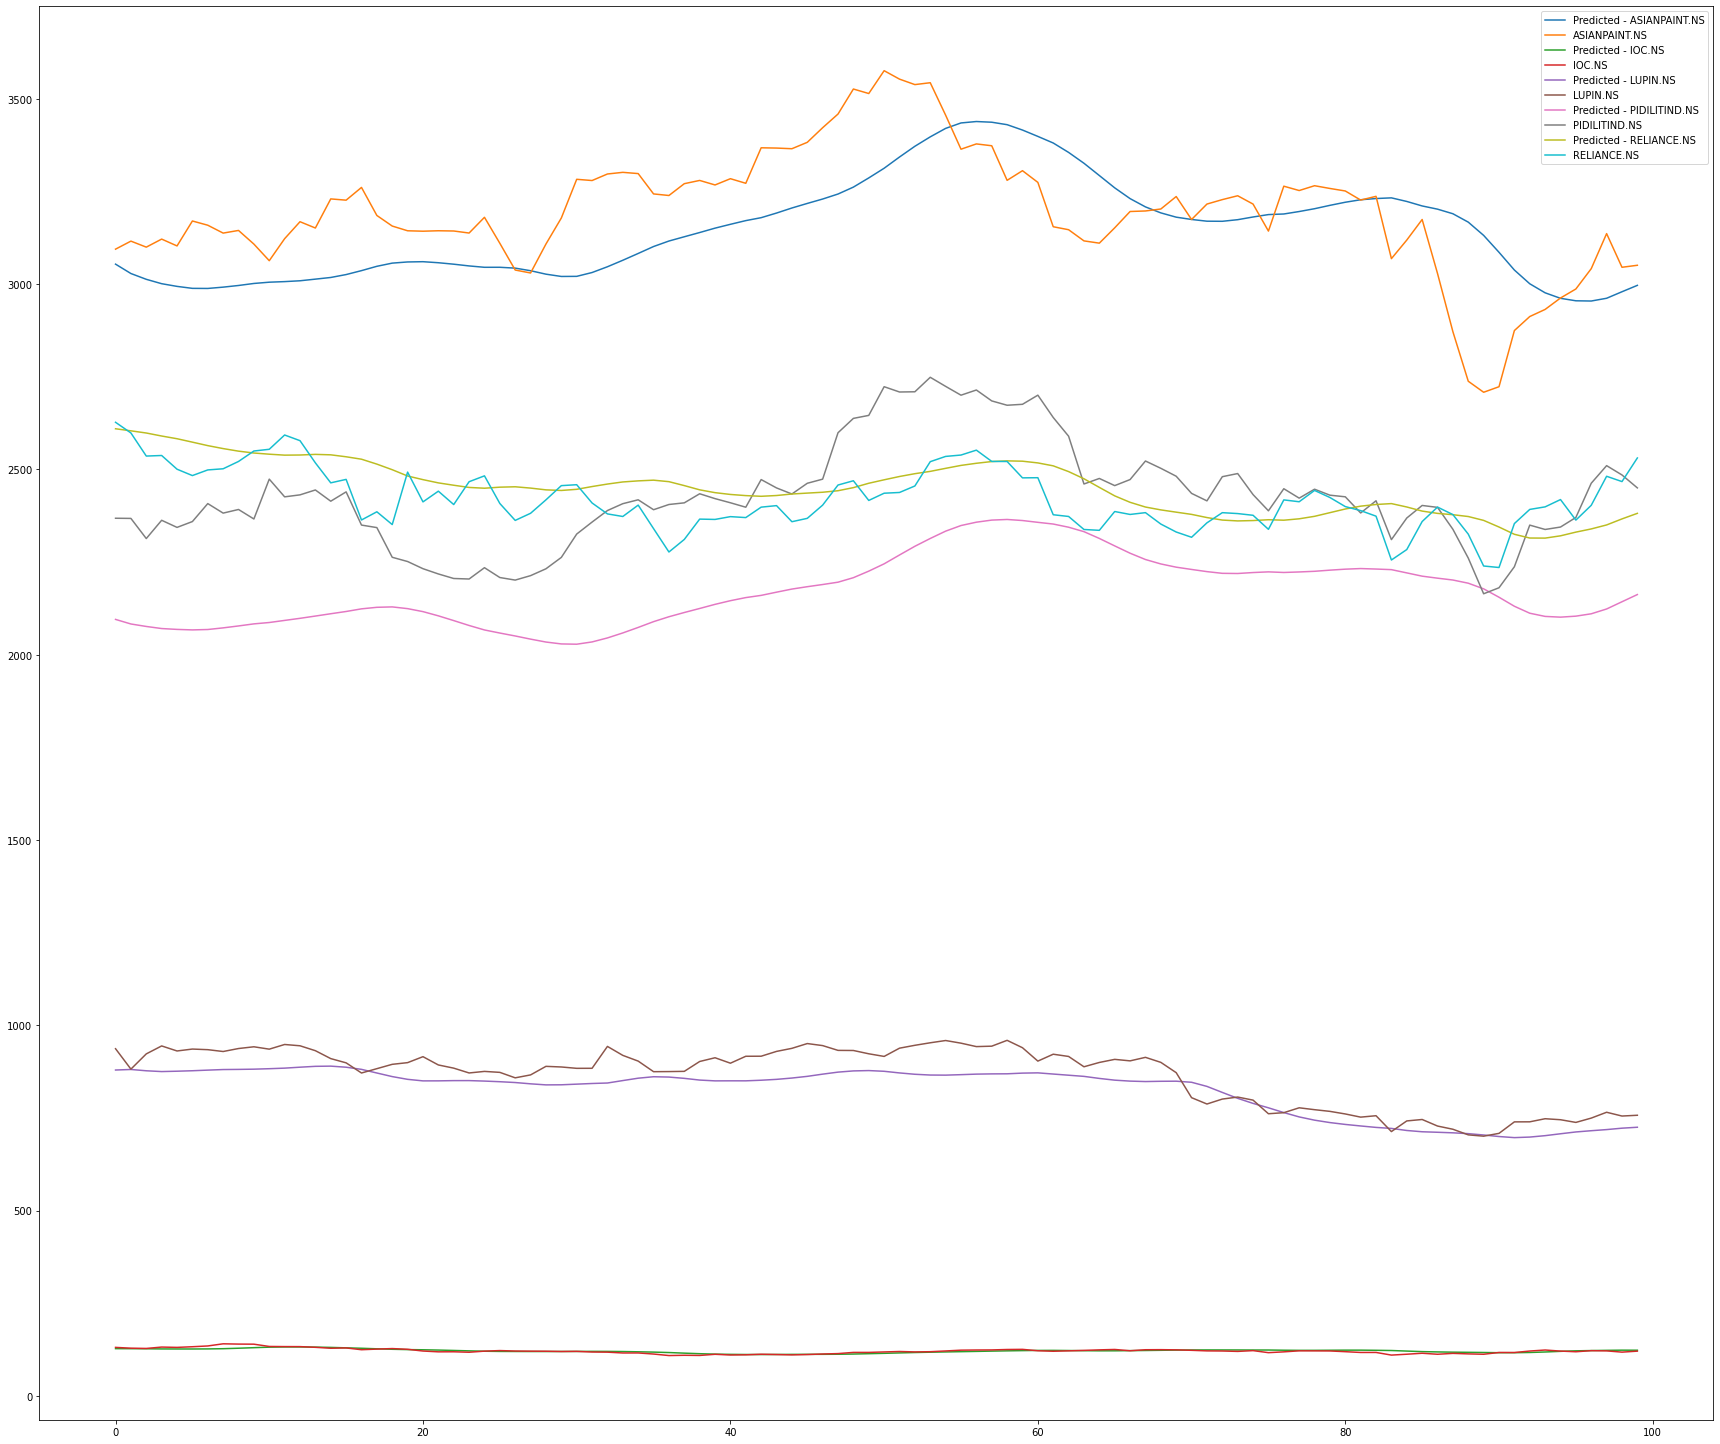

In [ ]:
score = model.evaluate(X_test_new, y_test_new)

print('Score: {}'.format(score))

yhat = model.predict(X_test_new)

# inverse transform is used to convert the scaled values back to original values

# predicted output
yhat = y_scale.inverse_transform(yhat)

# original output
y_test = y_scale.inverse_transform(y_test_new)

# Prediction plot
plt.figure(figsize = (30,26))

for i in range(len(tickers)):
  plt.plot(yhat[-100:, i], label = f'Predicted - {tickers[i]}')
  plt.plot(y_test[-100:, i], label = tickers[i])

plt.legend()
# plt.legend(handles = [pred, orig], labels = [[f'Predicted - {x}' for x in tickers], tickers])
plt.show()

## Next day stock price prediction (Portfolio)

In [ ]:
load_model = load_model("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print("Model loaded!")

Model loaded!


In [ ]:
df_pred = get_data(tickers, False)

[*********************100%***********************]  5 of 5 completed


In [ ]:
df_pred = df_pred["Close"]

In [ ]:
df_pred

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-21,3045.750000,118.000000,755.150024,2485.250000,2467.399902


In [ ]:
df_pred = df_pred.iloc[len(df_pred) - time_steps:len(df_pred), :]
df_pred = df_pred.values
df_pred

array([[3116.30004883,  128.6499939 ,  881.75      , 2368.        ,
        2598.60009766],
       [3100.10009766,  127.94999695,  922.90002441, 2313.64990234,
        2536.25      ],
       [3121.80004883,  131.6499939 ,  944.34997559, 2362.94995117,
        2537.80004883],
       [3103.35009766,  130.80000305,  930.75      , 2343.75      ,
        2500.80004883],
       [3170.64990234,  132.55000305,  935.90002441, 2359.5       ,
        2483.60009766],
       [3159.25      ,  134.6499939 ,  934.25      , 2408.        ,
        2498.85009766],
       [3138.        ,  140.44999695,  929.29998779, 2382.30004883,
        2501.94995117],
       [3145.14990234,  139.69999695,  937.34997559, 2392.10009766,
        2521.69995117],
       [3108.30004883,  139.44999695,  942.04998779, 2366.44995117,
        2549.89990234],
       [3063.5       ,  133.30000305,  935.65002441, 2474.        ,
        2554.55004883],
       [3122.89990234,  132.94999695,  948.25      , 2426.19995117,
        2593

In [ ]:
x_pred = x_scale.transform(df_pred)

print(x_pred.shape)

(100, 5)


In [ ]:
next_day_price = load_model.predict(x_pred.reshape(-1, x_pred.shape[0], x_pred.shape[1]))

In [ ]:
print(y_scale.inverse_transform(next_day_price))

[[3033.3398    116.084206  749.45996  2386.426    2505.0662  ]]


# Helper functions

## Calculate expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [ ]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN (252 is the approx number of trading days in a year)
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix * 252,weights)))

  # SHARPE RATIO (Assuming 0 risk free return. Alternative is to use a value of 0.02)
  sharpe_ratio = expected_return / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

  return (expected_return * 100).round(decimals = 2), (volatility * 100).round(decimals = 2)[0][0], sharpe_ratio.round(decimals = 2)[0][0]

## Calculate overall returns of portfolio with given weights

In [ ]:
def get_port_overall_returns(pct_change, weights):
  pass

# Fundamentals analyser (To be implemented)

In [ ]:
def fundamentals_analyser(tickers):
  pass

# Calculating percentage change and covariance matrix

In [16]:
pct_change = df.pct_change().dropna()
cov = np.cov(pct_change.values.T)

In [37]:
cov

array([[6.68411265e-04, 1.35955110e-04, 1.94519849e-04, 1.70379257e-04,
        1.30744511e-04, 1.84928207e-04, 1.53758459e-04, 1.73101113e-04,
        1.78395940e-04, 1.12078150e-04, 2.22572127e-04],
       [1.35955110e-04, 4.22692106e-04, 1.36849660e-04, 1.20234038e-04,
        8.55141901e-05, 1.31661925e-04, 1.19930119e-04, 1.31299491e-04,
        1.13156567e-04, 7.60990012e-05, 1.30178389e-04],
       [1.94519849e-04, 1.36849660e-04, 8.90307548e-04, 3.35555632e-04,
        1.65660374e-04, 2.27035357e-04, 2.07448646e-04, 2.10922927e-04,
        1.61073606e-04, 9.00502247e-05, 2.66440555e-04],
       [1.70379257e-04, 1.20234038e-04, 3.35555632e-04, 8.09413756e-04,
        9.89611046e-05, 1.67621310e-04, 1.46708105e-04, 1.60856034e-04,
        1.65400614e-04, 5.85456485e-05, 1.81905301e-04],
       [1.30744511e-04, 8.55141901e-05, 1.65660374e-04, 9.89611046e-05,
        4.41188277e-04, 1.44880858e-04, 1.46989528e-04, 1.55015300e-04,
        9.79406202e-05, 5.51653676e-05, 1.57950585e-

# Deep Learning Model for Portfolio Optimization [Method 1]

In [26]:
tf_port_data = tf.cast(tf.constant(df.iloc[1:]), float)

In [33]:
df.iloc[1:]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-28,118.330002,615.900024,81.371620,425.000000,937.150024,224.050003,282.100006,88.800003,246.300003,259.989990,66.500000
2017-03-29,117.190002,651.099976,81.340538,425.549988,932.950012,214.399994,288.450012,90.000000,249.000000,258.630005,69.050003
2017-03-30,118.489998,668.299988,81.216209,420.049988,940.400024,219.949997,291.049988,89.900002,256.149994,262.320007,68.300003
2017-03-31,117.445000,692.400024,80.625664,435.600006,949.450012,216.850006,293.399994,90.349998,266.700012,262.529999,66.550003
2017-04-03,120.254997,716.000000,80.812149,434.950012,961.549988,224.149994,293.149994,89.199997,271.899994,271.769989,67.150002
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,963.849976,978.750000,443.750000,4433.899902,1054.000000,532.799988,490.600006,227.949997,1279.599976,520.869995,197.100006
2022-03-22,938.049988,984.750000,465.899994,4457.700195,1051.849976,533.799988,493.700012,231.399994,1286.349976,513.090027,195.750000
2022-03-23,908.700012,995.049988,467.549988,4435.450195,1087.050049,533.599976,490.649994,234.300003,1300.250000,527.789978,195.750000


In [36]:
df.iloc[1:] / df.iloc[1]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-28,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-03-29,0.990366,1.057152,0.999618,1.001294,0.995518,0.956929,1.022510,1.013513,1.010962,0.994769,1.038346
2017-03-30,1.001352,1.085079,0.998090,0.988353,1.003468,0.981700,1.031726,1.012387,1.039992,1.008962,1.027068
2017-03-31,0.992521,1.124208,0.990833,1.024941,1.013125,0.967864,1.040057,1.017455,1.082826,1.009770,1.000752
2017-04-03,1.016268,1.162526,0.993124,1.023412,1.026036,1.000446,1.039170,1.004504,1.103938,1.045309,1.009774
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,8.145440,1.589138,5.453376,10.432706,1.124687,2.378041,1.739100,2.567004,5.195290,2.003423,2.963910
2022-03-22,7.927406,1.598880,5.725583,10.488706,1.122392,2.382504,1.750089,2.605856,5.222696,1.973499,2.943609
2022-03-23,7.679371,1.615603,5.745861,10.436353,1.159953,2.381611,1.739277,2.638513,5.279131,2.030040,2.943609


In [39]:
pd.DataFrame(np.multiply((df.iloc[1:] / df.iloc[1]).values, np.array([1 / port_len for x in range(port_len)])))

,0,1,2,3,4,5,6,7,8,9,10
0,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
1,0.090033,0.096105,0.090874,0.091027,0.090502,0.086994,0.092955,0.092138,0.091906,0.090434,0.094395
2,0.091032,0.098644,0.090735,0.089850,0.091224,0.089245,0.093793,0.092035,0.094545,0.091724,0.093370
3,0.090229,0.102201,0.090076,0.093176,0.092102,0.087988,0.094551,0.092496,0.098439,0.091797,0.090977
4,0.092388,0.105684,0.090284,0.093037,0.093276,0.090950,0.094470,0.091319,0.100358,0.095028,0.091798
...,...,...,...,...,...,...,...,...,...,...,...
1230,0.740495,0.144467,0.495761,0.948428,0.102244,0.216186,0.158100,0.233364,0.472299,0.182129,0.269446
1231,0.720673,0.145353,0.520508,0.953519,0.102036,0.216591,0.159099,0.236896,0.474791,0.179409,0.267601
1232,0.698125,0.146873,0.522351,0.948759,0.105450,0.216510,0.158116,0.239865,0.479921,0.184549,0.267601
1233,0.692785,0.147618,0.536372,0.958064,0.106124,0.221359,0.156972,0.245188,0.471284,0.188801,0.267464


In [ ]:
data = tf.divide(tf_port_data, tf_port_data[0])  
data.shape

TensorShape([1235, 11])

In [33]:
def sharpe_loss(_, y_pred):
  '''
  data.shape -> (lookback_period, port_len)
  y_pred.shape -> (None, port_len)
  '''

  # make all time-series start at 1 (Scaling down prices for fast multiplication)
  data = tf.divide(tf_port_data, tf_port_data[0])  
            
  # value of the portfolio after allocations applied
  portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [34]:
# Historical data with returns
df_w_ret = np.concatenate([df.values[1:], df.pct_change().dropna().values[0:]], axis=1)

df_w_ret.shape

(1235, 22)

In [35]:
opt_model = Sequential([
            LSTM(64, input_shape=df_w_ret.shape),
            Flatten(),
            Dense(port_len, activation='softmax') 
        ])

In [36]:
opt_model.compile(loss=sharpe_loss, optimizer='adam')

In [37]:
opt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22272     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 11)                715       
                                                                 
Total params: 22,987
Trainable params: 22,987
Non-trainable params: 0
_________________________________________________________________


In [38]:
fit_predict_data = df_w_ret[np.newaxis,:]
fit_predict_data.shape

(1, 1235, 22)

In [39]:
with tf.device('/device:GPU:0'):
  opt_model.fit(fit_predict_data, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
(None, 11)
(None, 11)
1/1 [==============================] - 13s 13s/step - loss: -0.0754
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: -0.0758
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: -0.0762
Epoch 4/50
1/1 [==============================] - 6s 6s/step - loss: -0.0766
Epoch 5/50
1/1 [==============================] - 6s 6s/step - loss: -0.0769
Epoch 6/50
1/1 [==============================] - 6s 6s/step - loss: -0.0773
Epoch 7/50
1/1 [==============================] - 6s 6s/step - loss: -0.0777
Epoch 8/50
1/1 [==============================] - 6s 6s/step - loss: -0.0780
Epoch 9/50
1/1 [==============================] - 7s 7s/step - loss: -0.0784
Epoch 10/50
1/1 [==============================] - 6s 6s/step - loss: -0.0787
Epoch 11/50
1/1 [==============================] - 6s 6s/step - loss: -0.0791
Epoch 12/50
1/1 [==============================] - 6s 6s/step - loss: -0.0794
Epoch 13/50
1/1 [==============================] 

In [40]:
pred_weights_1 = opt_model.predict(fit_predict_data).T
pred_weights_1 = pd.DataFrame(pred_weights_1)
pred_weights_1

,0
0,0.164628
1,0.028709
2,0.128365
3,0.154148
4,0.033979
5,0.045208
6,0.027254
7,0.021994
8,0.191584
9,0.130871


In [41]:
erDLm1, cvDLm1, srDLm1 = get_port_stats(pct_change, pred_weights_1, cov)

Expected Returns: 39.98%
Annual Volatility: 24.0%
Sharpe Ratio: 1.67


# Deep learning Model for Portfolio Optimization [Method 2] (Not important)

In [57]:
def sharpe_loss_2(_, y_pred):

  y_pred = tf.cast(y_pred, dtype = tf.float64)
  cov_tensor = tf.convert_to_tensor(cov, dtype=tf.float64)
  pct_change_tensor = tf.convert_to_tensor(pct_change, dtype=tf.float64)

  # EXPECTED ANNUAL RETURN
  annual_returns = K.mean(pct_change_tensor) * 252
  # find expected portfolio returns
  expected_return = tf.reduce_sum(tf.transpose(y_pred) * annual_returns)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = tf.sqrt(tf.matmul(y_pred,tf.matmul(cov_tensor*252,tf.transpose(y_pred))))

  # SHARPE RATIO (Assuming 0 risk free return)
  sharpe_ratio = expected_return / volatility

  if sharpe_ratio > 0:
    return -sharpe_ratio
  else:
    return sharpe_ratio

In [58]:
def gen_model(input_shape, outputs):
  model = Sequential([
              GRU(128, input_shape=input_shape, return_sequences = True),
              GRU(64),
              Flatten(),
              Dense(outputs, activation='softmax')
          ])

  # FOR TESTING:
  # model.compile(loss=sharpe_loss_2, optimizer='adam', run_eagerly=True)
  
  # FOR PRODUCTION:
  model.compile(loss=sharpe_loss_2, optimizer='adam')

  return model

In [59]:
# Historical data concatenated with returns (for momentum purpose as explained in the paper "Deep
# learning for portfolio optimization")
df_w_ret = np.concatenate([ df.values[1:], df.pct_change().values[1:] ], axis=1)

In [60]:
df_w_ret[0]

array([ 1.18330002e+02,  6.15900024e+02,  8.13716202e+01,  4.25000000e+02,
        9.37150024e+02,  2.24050003e+02,  2.82100006e+02,  8.88000031e+01,
        2.46300003e+02,  2.59989990e+02,  6.65000000e+01,  1.56209738e-02,
       -7.49329380e-03,  7.31054078e-03, -2.35253122e-04,  1.07312468e-02,
       -1.27781182e-02,  9.48289061e-03,  1.71821300e-02,  2.51821147e-02,
       -4.82300389e-03, -5.23557939e-03])

In [61]:
opt_model_x = df_w_ret[np.newaxis, :]

opt_model_x.shape

(1, 1235, 22)

In [62]:
opt_model_2 = gen_model(np.array([opt_model_x.shape[1], opt_model_x.shape[2]]), port_len)

In [63]:
with tf.device('/device:GPU:0'):
  # Here Y [np.zeros((1, port_len))] does not matter because we don't use y_true in 
  # the custom loss function
  opt_model_2.fit(opt_model_x, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
1/1 [==============================] - 17s 17s/step - loss: -1.4235
Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: -1.5180
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: -1.5441
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: -1.5496
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: -1.5603
Epoch 6/50
1/1 [==============================] - 11s 11s/step - loss: -1.5730
Epoch 7/50
1/1 [==============================] - 12s 12s/step - loss: -1.5835
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: -1.5958
Epoch 9/50
1/1 [==============================] - 11s 11s/step - loss: -1.6060
Epoch 10/50
1/1 [==============================] - 11s 11s/step - loss: -1.6110
Epoch 11/50
1/1 [==============================] - 11s 11s/step - loss: -1.6077
Epoch 12/50
1/1 [==============================] - 11s 11s/step - loss: -1.6036
Epoch 13/50
1/1 [==============================] 

In [64]:
pred_weights_2 = opt_model_2.predict(opt_model_x).T
pred_weights_2 = pd.DataFrame(pred_weights_2)
pred_weights_2

,0
0,0.044639
1,0.196646
2,0.005666
3,0.076830
4,0.206292
5,0.006700
6,0.061958
7,0.029194
8,0.118983
9,0.248855


In [65]:
erDL, cvDL, srDL = get_port_stats(pct_change, pred_weights_2, cov)

Expected Returns: 23.9%
Annual Volatility: 20.22%
Sharpe Ratio: 1.18


In [ ]:
get_port_overall_returns(pred_weights_2)

# Statistical models (PyPortfolioOpt)

In [66]:
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns

<AxesSubplot:xlabel='Date'>

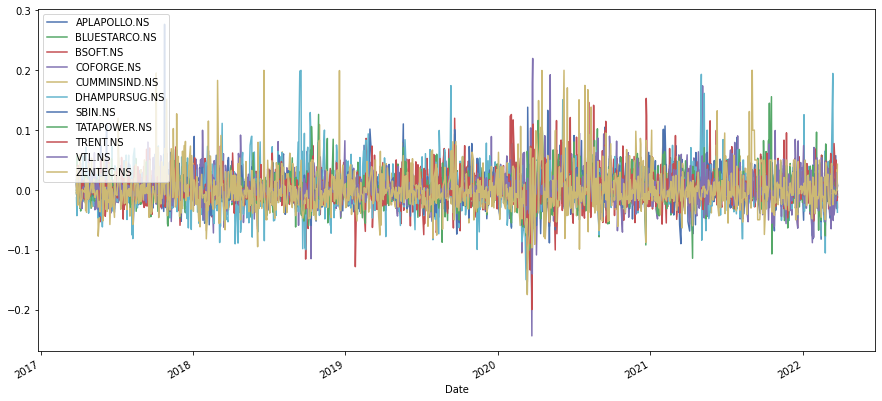

In [67]:
pct_change.plot(label = tickers, figsize = (15,7))

## HRP (Hierarchical Risk Parity)

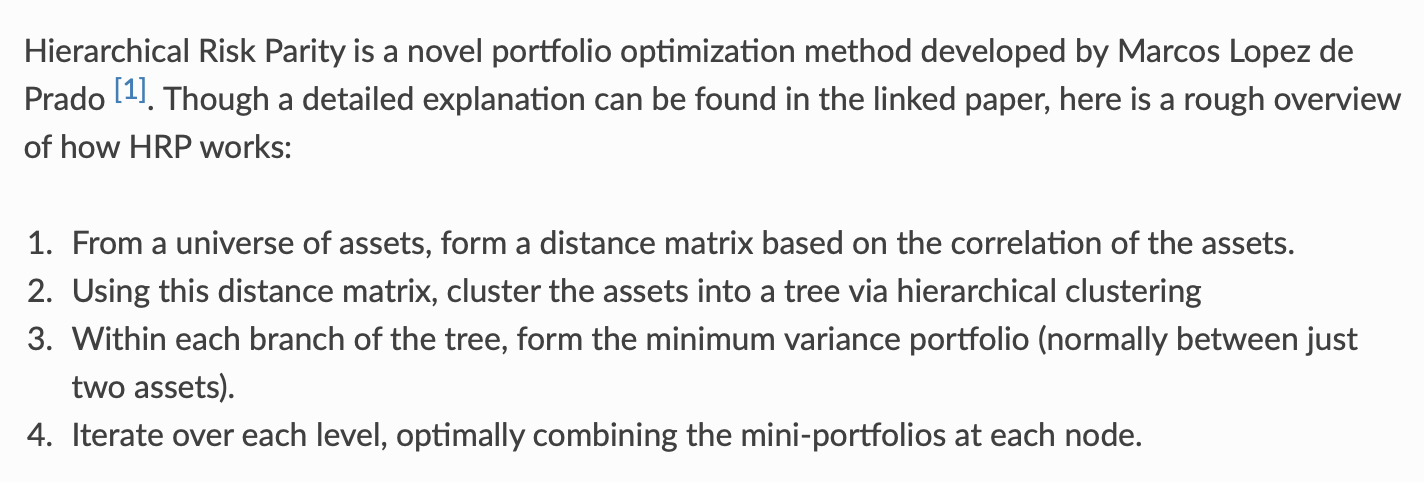

Here since Minimum variance portfolio is formed, the returns will obviously be low.

In [68]:
# Using Hierarchical Risk Parity method to compute optimized portfolio weights
hrp = HRPOpt(pct_change)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('APLAPOLLO.NS', 0.07546),
             ('BLUESTARCO.NS', 0.15891),
             ('BSOFT.NS', 0.06259),
             ('COFORGE.NS', 0.077),
             ('CUMMINSIND.NS', 0.11432),
             ('DHAMPURSUG.NS', 0.04219),
             ('SBIN.NS', 0.06923),
             ('TATAPOWER.NS', 0.06338),
             ('TRENT.NS', 0.10214),
             ('VTL.NS', 0.18296),
             ('ZENTEC.NS', 0.05183)])

In [69]:
risk_models.sample_cov(df) # covariance matrix

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168440,0.034261,0.049019,0.042936,0.032948,0.046602,0.038747,0.043621,0.044956,0.028244,0.056088
BLUESTARCO.NS,0.034261,0.106518,0.034486,0.030299,0.021550,0.033179,0.030222,0.033087,0.028515,0.019177,0.032805
BSOFT.NS,0.049019,0.034486,0.224358,0.084560,0.041746,0.057213,0.052277,0.053153,0.040591,0.022693,0.067143
COFORGE.NS,0.042936,0.030299,0.084560,0.203972,0.024938,0.042241,0.036970,0.040536,0.041681,0.014754,0.045840
CUMMINSIND.NS,0.032948,0.021550,0.041746,0.024938,0.111179,0.036510,0.037041,0.039064,0.024681,0.013902,0.039804
DHAMPURSUG.NS,0.046602,0.033179,0.057213,0.042241,0.036510,0.332854,0.060563,0.061423,0.035120,0.035645,0.062859
SBIN.NS,0.038747,0.030222,0.052277,0.036970,0.037041,0.060563,0.143619,0.063926,0.041848,0.025423,0.048680
TATAPOWER.NS,0.043621,0.033087,0.053153,0.040536,0.039064,0.061423,0.063926,0.156870,0.041168,0.029118,0.059276
TRENT.NS,0.044956,0.028515,0.040591,0.041681,0.024681,0.035120,0.041848,0.041168,0.138773,0.020473,0.039236
VTL.NS,0.028244,0.019177,0.022693,0.014754,0.013902,0.035645,0.025423,0.029118,0.020473,0.102601,0.033674


In [70]:
weightsdf1 = pd.DataFrame.from_dict(weights, orient="index")
weightsdf1 = weightsdf1.rename({0: 'weights'}, axis=1)
weightsdf1

,weights
APLAPOLLO.NS,0.07546
BLUESTARCO.NS,0.15891
BSOFT.NS,0.06259
COFORGE.NS,0.07700
CUMMINSIND.NS,0.11432
DHAMPURSUG.NS,0.04219
SBIN.NS,0.06923
TATAPOWER.NS,0.06338
TRENT.NS,0.10214
VTL.NS,0.18296


<AxesSubplot:xlabel='Weight'>

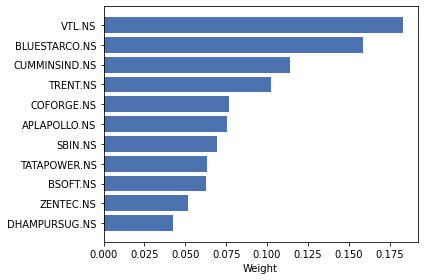

In [71]:
plotting.plot_weights(weights)

In [72]:
weightsdf1.iloc[:, 0].sum()

1.00001

In [73]:
hrp.portfolio_performance(risk_free_rate=0, verbose=True)

Expected annual return: 29.0%
Annual volatility: 21.1%
Sharpe Ratio: 1.37


(0.28972796881456053, 0.21075545040485405, 1.3747116302710225)

In [74]:
erW1Plib, cvW1Plib, srW1Plib = get_port_stats(pct_change, weightsdf1, cov)

Expected Returns: 28.97%
Annual Volatility: 21.08%
Sharpe Ratio: 1.37


<AxesSubplot:>

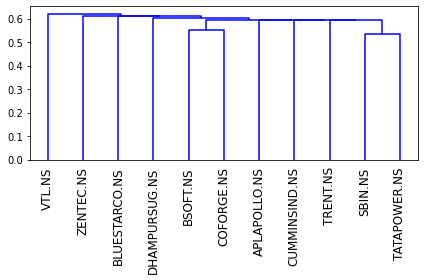

In [75]:
plotting.plot_dendrogram(hrp) 

## CLA (Critical Line Algorithm)

In [76]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df) # covariance matrix

In [77]:
mu

APLAPOLLO.NS     0.517715
BLUESTARCO.NS    0.100080
BSOFT.NS         0.429807
COFORGE.NS       0.612740
CUMMINSIND.NS    0.032851
DHAMPURSUG.NS    0.186713
SBIN.NS          0.121740
TATAPOWER.NS     0.230593
TRENT.NS         0.402641
VTL.NS           0.161073
ZENTEC.NS        0.255709
dtype: float64

In [78]:
S

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168440,0.034261,0.049019,0.042936,0.032948,0.046602,0.038747,0.043621,0.044956,0.028244,0.056088
BLUESTARCO.NS,0.034261,0.106518,0.034486,0.030299,0.021550,0.033179,0.030222,0.033087,0.028515,0.019177,0.032805
BSOFT.NS,0.049019,0.034486,0.224358,0.084560,0.041746,0.057213,0.052277,0.053153,0.040591,0.022693,0.067143
COFORGE.NS,0.042936,0.030299,0.084560,0.203972,0.024938,0.042241,0.036970,0.040536,0.041681,0.014754,0.045840
CUMMINSIND.NS,0.032948,0.021550,0.041746,0.024938,0.111179,0.036510,0.037041,0.039064,0.024681,0.013902,0.039804
DHAMPURSUG.NS,0.046602,0.033179,0.057213,0.042241,0.036510,0.332854,0.060563,0.061423,0.035120,0.035645,0.062859
SBIN.NS,0.038747,0.030222,0.052277,0.036970,0.037041,0.060563,0.143619,0.063926,0.041848,0.025423,0.048680
TATAPOWER.NS,0.043621,0.033087,0.053153,0.040536,0.039064,0.061423,0.063926,0.156870,0.041168,0.029118,0.059276
TRENT.NS,0.044956,0.028515,0.040591,0.041681,0.024681,0.035120,0.041848,0.041168,0.138773,0.020473,0.039236
VTL.NS,0.028244,0.019177,0.022693,0.014754,0.013902,0.035645,0.025423,0.029118,0.020473,0.102601,0.033674


In [79]:
cla = CLA(mu, S)
cla.max_sharpe()
weights2 = cla.clean_weights()
weightsdf2 = pd.DataFrame.from_dict(weights2, orient="index")
weightsdf2 = weightsdf2.rename({0: 'weights'}, axis=1)
weightsdf2

,weights
APLAPOLLO.NS,0.31456
BLUESTARCO.NS,0.00000
BSOFT.NS,0.06248
COFORGE.NS,0.33470
CUMMINSIND.NS,0.00000
DHAMPURSUG.NS,0.00000
SBIN.NS,0.00000
TATAPOWER.NS,0.00000
TRENT.NS,0.23331
VTL.NS,0.05495


<AxesSubplot:xlabel='Weight'>

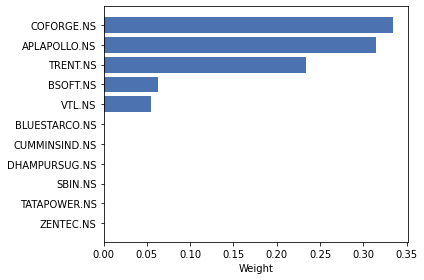

In [80]:
plotting.plot_weights(weights2)

In [81]:
erW2Plib, cvW2Plib, srW2Plib = cla.portfolio_performance(risk_free_rate=0, verbose=True)
erW2Plib, cvW2Plib, srW2Plib = (erW2Plib * 100).round(decimals = 2), (cvW2Plib * 100).round(decimals = 2), (srW2Plib).round(decimals = 2)

Expected annual return: 49.8%
Annual volatility: 28.2%
Sharpe Ratio: 1.77


<AxesSubplot:xlabel='Volatility', ylabel='Return'>

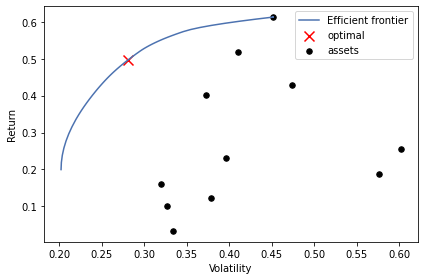

In [82]:
plotting.plot_efficient_frontier(cla)

# Statistical Models (RiskFolio-Lib) [Best Library]

In [42]:
# Calculating returns
Y = pct_change
Y

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-28,0.015621,-0.007493,0.007311,-0.000235,0.010731,-0.012778,0.009483,0.017182,0.025182,-0.004823,-0.005236
2017-03-29,-0.009634,0.057152,-0.000382,0.001294,-0.004482,-0.043071,0.022510,0.013513,0.010962,-0.005231,0.038346
2017-03-30,0.011093,0.026417,-0.001528,-0.012924,0.007985,0.025886,0.009014,-0.001111,0.028715,0.014267,-0.010862
2017-03-31,-0.008819,0.036062,-0.007271,0.037019,0.009624,-0.014094,0.008074,0.005006,0.041187,0.000801,-0.025622
2017-04-03,0.023926,0.034084,0.002313,-0.001492,0.012744,0.033664,-0.000852,-0.012728,0.019497,0.035196,0.009016
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,0.057317,-0.004070,-0.000451,0.005180,0.030001,0.019030,-0.022514,-0.016397,0.013906,-0.013485,-0.007303
2022-03-22,-0.026768,0.006130,0.049915,0.005368,-0.002040,0.001877,0.006319,0.015135,0.005275,-0.014936,-0.006849
2022-03-23,-0.031288,0.010459,0.003542,-0.004991,0.033465,-0.000375,-0.006178,0.012532,0.010806,0.028650,0.000000


## HRP (Hierarchical Risk Parity)

Reference - https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [43]:
model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
rf = 0 # Risk free rate
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
linkage = 'single' # Linkage method used to build clusters
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios
max_k = port_len

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels[permutation], rotation=90, ha="center")
/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


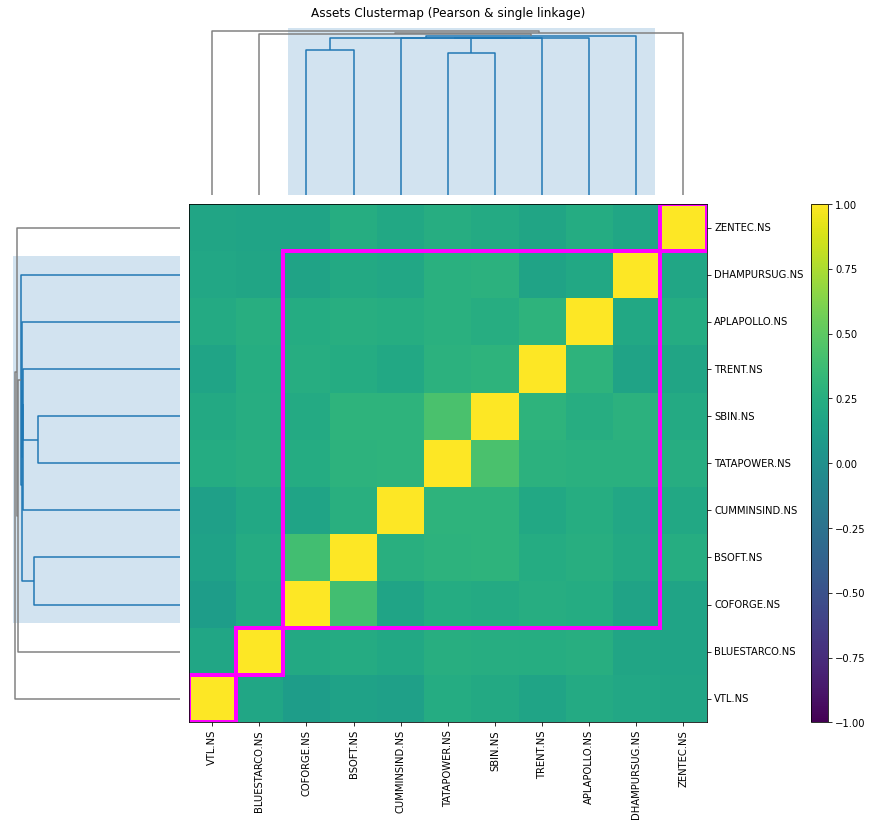

In [44]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [45]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [46]:
# Estimate optimal portfolio:

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      leaf_order=leaf_order,
                      hist=hist)

display(w1.T)

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
weights,0.070802,0.134774,0.053084,0.245831,0.057112,0.036948,0.07165,0.085402,0.1291,0.079666,0.035631


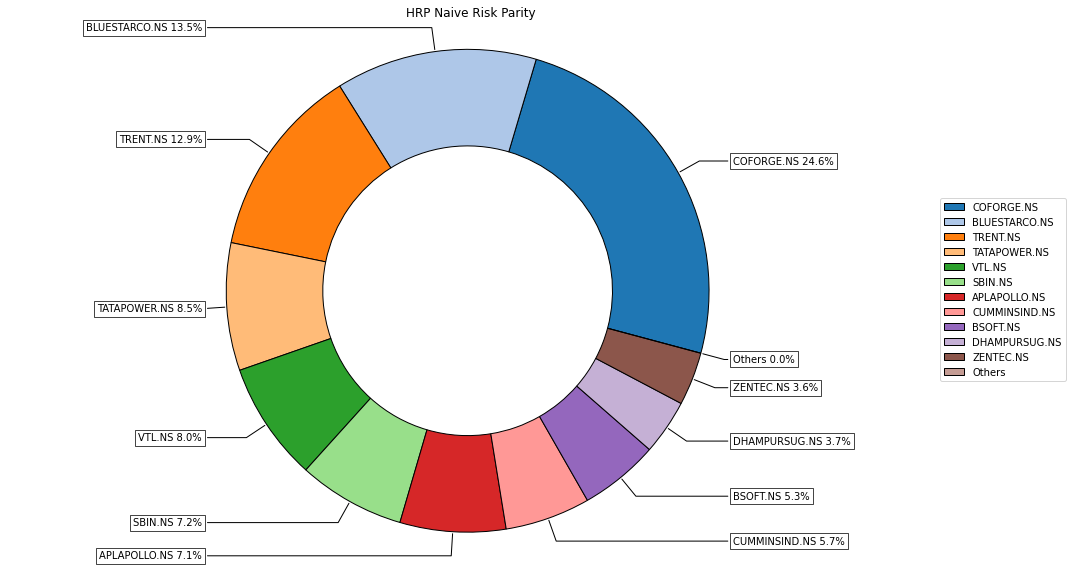

In [47]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

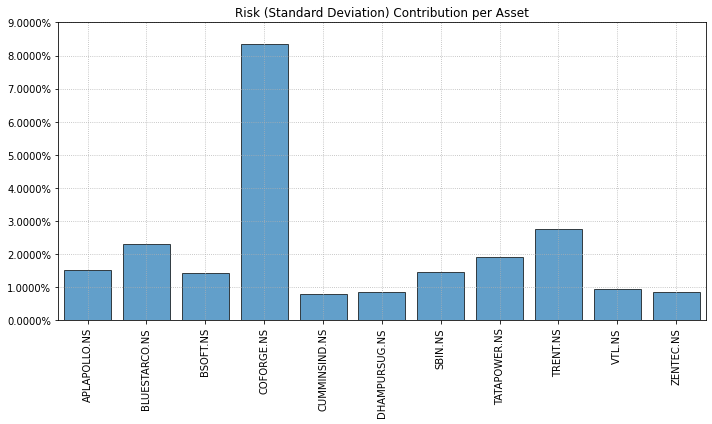

In [48]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w1,
                 cov=port1.cov, 
                 returns=port1.returns, 
                 ax=None)

In [49]:
erW1, cvW1, srW1 = get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 36.1%
Annual Volatility: 23.27%
Sharpe Ratio: 1.55


In [ ]:
returns1 = get_port_overall_returns(port1.returns, w1)
rp.RiskFunctions.CVaR_Hist(returns1)

## HERC (Hierarchical Equal Risk Contribution)

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [50]:
model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
linkage = 'complete' # Linkage method used to build clusters
max_k = port_len # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels[permutation], rotation=90, ha="center")
/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


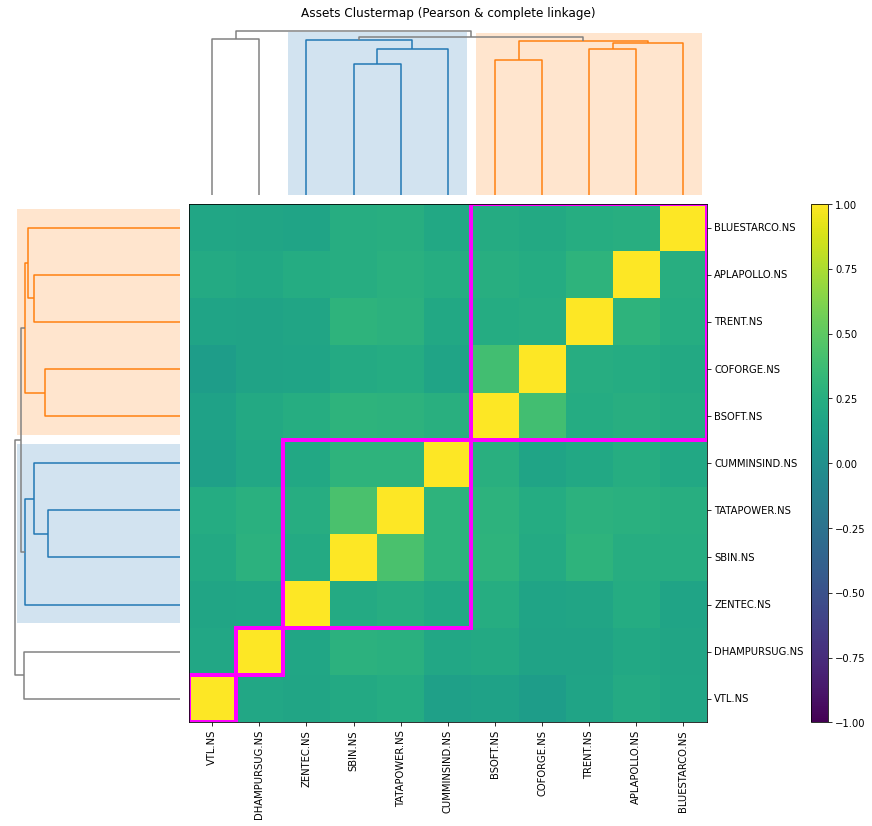

In [51]:
ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [52]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

In [53]:
# Estimate optimal portfolio:

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w2.T)

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
weights,0.058923,0.096302,0.044088,0.146255,0.042747,0.131959,0.069653,0.050672,0.139261,0.184817,0.035323


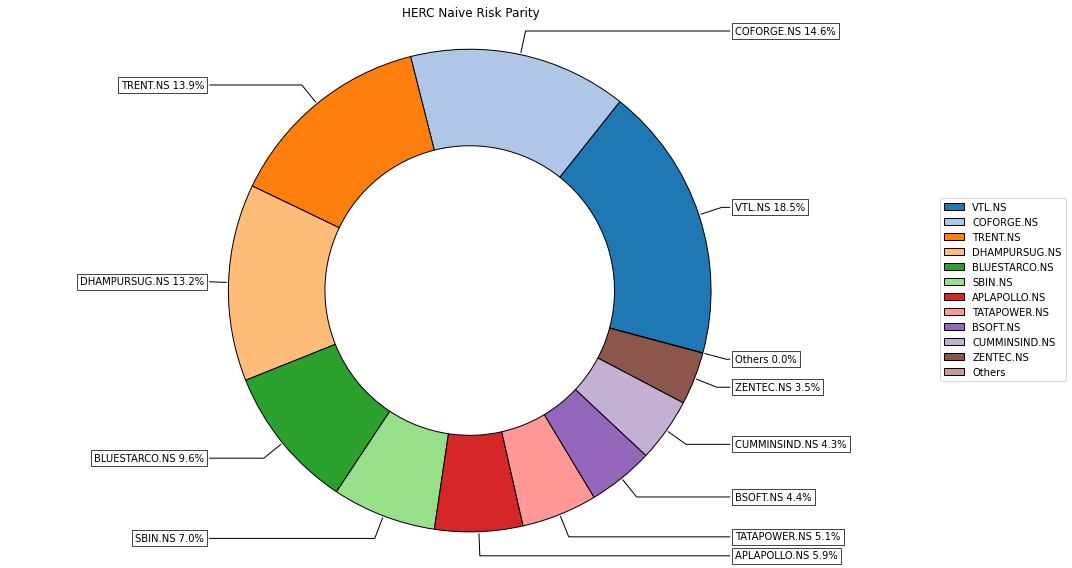

In [54]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

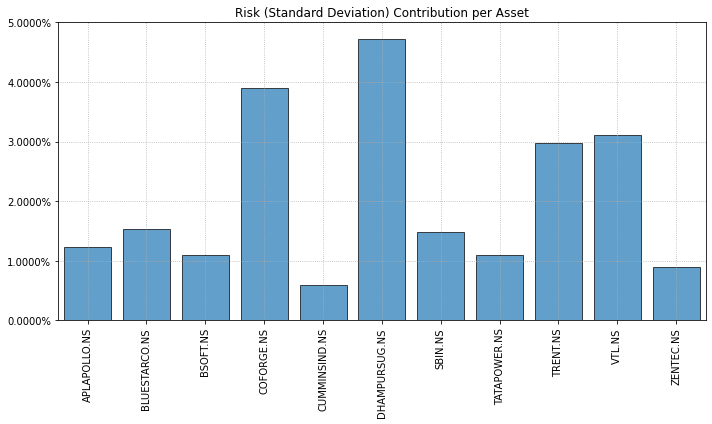

In [55]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [56]:
erW2, cvW2, srW2 = get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 33.28%
Annual Volatility: 22.65%
Sharpe Ratio: 1.47


In [ ]:
returns2 = get_port_overall_returns(port2.returns, w2)
rp.RiskFunctions.CVaR_Hist(returns2)

# Comparsion of HRP, HERC and DL models

In [122]:
comparison_models_len = 5

In [89]:
pred_weights_1_index_changed = pred_weights_1.reset_index(drop = True)
pred_weights_1_index_changed = pred_weights_1_index_changed.set_index(w1.index)
pred_weights_1_index_changed = pred_weights_1_index_changed.rename({0: 'weights'}, axis=1)

# pred_weights_2_index_changed = pred_weights_2.reset_index(drop = True)
# pred_weights_2_index_changed = pred_weights_2_index_changed.set_index(w1.index)
# pred_weights_2_index_changed = pred_weights_2_index_changed.rename({0: 'weights'}, axis=1)

In [90]:
compare_dl_w1_w2 = pd.concat([pred_weights_1_index_changed,
                              # pred_weights_2_index_changed, 
                              weightsdf1,
                              w1,
                              weightsdf2,
                              w2], 
                             keys=["DL Model Weights",
                                   # "DL Model Weights (Method 2)", 
                                   "HRP Weights (PyPortfolioOpt)",
                                   "HRP Weights (Riskfolio lib)",
                                   "CLA (PyPortfolioOpt)", 
                                   "HERC Weights (Riskfolio lib)"], 
                             axis= 1)

compare_dl_w1_w2

,DL Model Weights,HRP Weights [Min Variance] (PyPortfolioOpt),HRP Weights (Riskfolio lib),CLA (PyPortfolioOpt),HERC Weights (Riskfolio lib)
,weights,weights,weights,weights,weights
APLAPOLLO.NS,0.164628,0.07546,0.070802,0.31456,0.058923
BLUESTARCO.NS,0.028709,0.15891,0.134774,0.00000,0.096302
BSOFT.NS,0.128365,0.06259,0.053084,0.06248,0.044088
COFORGE.NS,0.154148,0.07700,0.245831,0.33470,0.146255
CUMMINSIND.NS,0.033979,0.11432,0.057112,0.00000,0.042747
DHAMPURSUG.NS,0.045208,0.04219,0.036948,0.00000,0.131959
SBIN.NS,0.027254,0.06923,0.071650,0.00000,0.069653
TATAPOWER.NS,0.021994,0.06338,0.085402,0.00000,0.050672
TRENT.NS,0.191584,0.10214,0.129100,0.23331,0.139261


In [91]:
def get_stats_df(er, cv, sr, col_name):
  stats_df = pd.DataFrame(np.array([er, cv, sr]).T, index=["Expected Returns", "Annual Volatility", "Sharpe Ratio"])
  stats_df = stats_df.rename({ 0: col_name }, axis = 1)
  
  return stats_df

In [94]:
port_stats_dl1_dl2_w1_w2 = pd.concat([get_stats_df(erDLm1, cvDLm1, srDLm1, "DL Model"),
                                 # get_stats_df(erDL, cvDL, srDL, "DL Model (Method 2)"),
                                 get_stats_df(erW1Plib, cvW1Plib, srW1Plib, 
                                              "HRP (PyPortfolioOpt)"),
                                 get_stats_df(erW1, cvW1, srW1, "HRP (Riskfolio lib)"),
                                 get_stats_df(erW2Plib, cvW2Plib, srW2Plib, "CLA (PyPortfolioOpt)"),
                                 get_stats_df(erW2, cvW2, srW2, "HERC (Riskfolio lib)")], 
                                axis = 1)

port_stats_dl1_dl2_w1_w2

,DL Model,HRP (PyPortfolioOpt),HRP (Riskfolio lib),CLA (PyPortfolioOpt),HERC (Riskfolio lib)
Expected Returns,39.98,28.97,36.10,49.76,33.28
Annual Volatility,24.00,21.08,23.27,28.15,22.65
Sharpe Ratio,1.67,1.37,1.55,1.77,1.47


## Plotting Risk contribution of each asset for each method

In [126]:
colors = ["blue", "red", "green", "yellow", "pink"]
weights_list = [pred_weights_1_index_changed, weightsdf1, w1, weightsdf2, w2] 
title_list = ["DL Model Weights",
            "HRP Weights (PyPortfolioOpt)",
            "HRP Weights (Riskfolio lib)",
            "CLA (PyPortfolioOpt)", 
            "HERC Weights (Riskfolio lib)"]

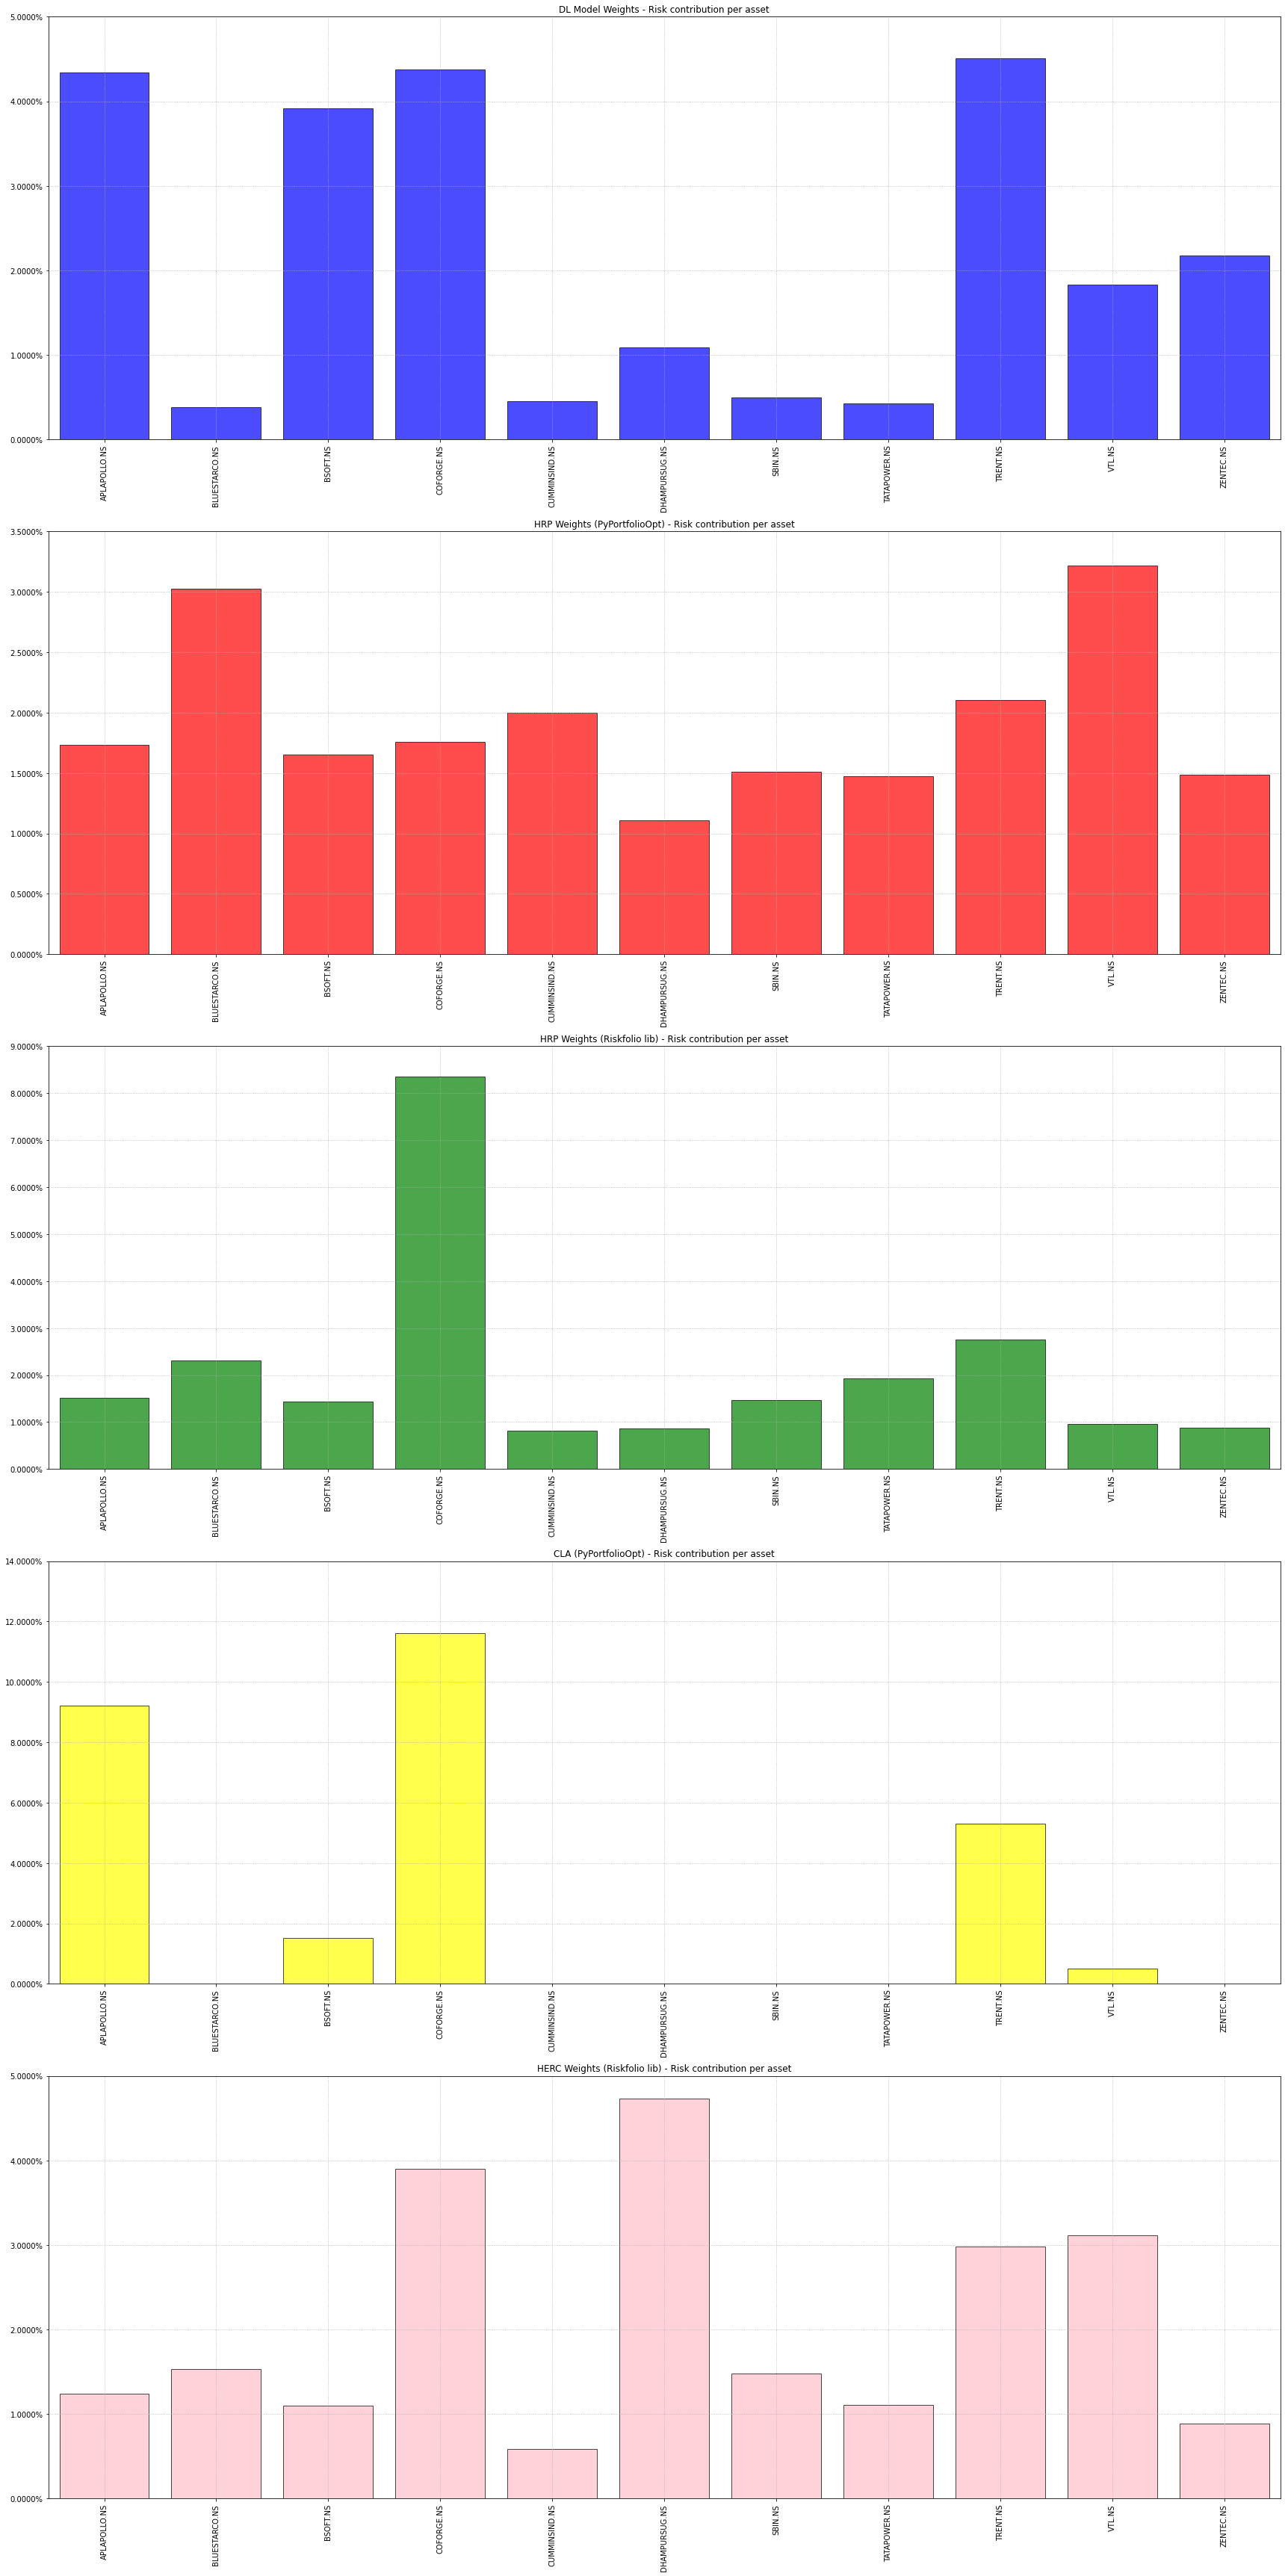

In [128]:
# Plotting the risk contribution graph of each asset for each comparison method

figure, axis = plt.subplots(comparison_models_len, 1, figsize=(24,48), facecolor=(1, 1, 1)) # (rows, cols, figsize, facecolor)

for i in range(comparison_models_len):
  rp.plot_risk_con(w=weights_list[i],
                  cov=cov, 
                  color=colors[i],
                  returns=pct_change,
                  ax = axis[i])
  
  axis[i].set_title(title_list[i] + " - Risk contribution per asset")
